In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from scipy.optimize import linear_sum_assignment
from matplotlib import animation, rc
from time import time
import sys
sns.set()
# Import Tabu Sampler
from tabu_class import tabu_sampler

%matplotlib notebook

@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

The model is the Sherrington-Kilpatrick model, which is a spin-glass model with a fully connected graph and random interactions. For dimension $n$, we have the space $X = \{-1, 1\}^n$. Let $\{ J_{ij} \}_{i, j \in L_n^2}$ be a collection of random variables such that each $J_{ij} \sim \mathcal{N}(0, (2n)^{-1}))$. We can write the Hamiltonian of the system
\begin{equation}
-H(\mathbf{x}) = \frac 1 n \sum_{i=1}^n\sum_{j=1}^n J_{ij} x_i x_j + h \sum_{l=1}^n x_l = \frac 1 n \sum_{i=1}^n x_i \sum_{j \neq i} J_{ij} x_j + h\sum_{l=1}^n x_l + \frac{J_{ll}}{nh},
\end{equation}
since $x_i^2 = 1$. The generator on $X$ is in this case given by $\phi_i \mathbf x = -1 \cdot x_i$, in a terrible abuse of notation. For the samplers, we want to calculate the jump rates
\begin{equation}
\lambda_i(\mathbf x) = g\Big (\frac{\pi(\phi_i \mathbf x)}{\pi(\mathbf x)}\Big ) = g\Big (\exp \Big \{ H(\phi_i \mathbf x) - H( \mathbf x) \Big \}\Big ) = g\Big (\exp \Big \{ 2hx_i + 2x_i \sum_{j\neq i} J_{ij} x_j \Big \} \Big ),
\end{equation}
for a locally balancing function $g: \mathbb R \rightarrow \mathbb R$. 

In [2]:
n_side = 100
n = n_side**2
h = 1
J = np.zeros((n,n))
J[np.triu_indices(n, 1)] = np.random.normal(size=np.sum(np.arange(0, n)), scale=10*np.sqrt(2*n)**-1)
J[np.tril_indices(n, -1)] = J[np.triu_indices(n, 1)]
J_diag = np.random.normal(size=n)

In [3]:
@numba.njit()
def energy_func(current_state, n=n, J=J, J_diag=J_diag, h=h):
    first_part = - 1/n * np.sum(J_diag)
    second_part = 0
    
    for i in np.arange(0, n):
        for j in np.arange(i+1, n):
            second_part -= 2/n * current_state[i] * current_state[j] * J[i, j]
            
    third_part = -h * np.sum(current_state)
    
    return first_part + second_part + third_part

def calc_rates(current_state, jump_rates=0, jump_rates_sum=0, generator_index=0, n=n, J=J, J_diag=J_diag, h=h):
    rates = np.zeros(n)
    
    for i in np.arange(0, n):
        rates[i] = 4 * current_state[i] * (1/2*h + 1/n * np.sum(J[i, :] * current_state))# 2 * h * current_state[i] + 2/n * current_state[i] * np.sum(J[i, :] * current_state)
    
    exponential_rates = np.exp(-rates)
    exponential_rates_g = np.sqrt(exponential_rates)
    
    return exponential_rates_g

def calc_rates_barker(current_state, jump_rates=0, jump_rates_sum=0, generator_index=0, n=n, J=J, J_diag=J_diag, h=h):
    rates = np.zeros(n)
    
    for i in np.arange(0, n):
        rates[i] = 4 * current_state[i] * (1/2*h + 1/n * np.sum(J[i, :] * current_state))
    
    exponential_rates_g = 1/(1+np.exp(rates))
    
    return exponential_rates_g

def upd_rates(current_state, jump_rates, jump_rates_sum, generator_index, n=n, J=J, J_diag=J_diag, h=h):
    # Convert back to logarithms
    log_rates = 2 * np.log(jump_rates)
    kept_rate = -1*log_rates[generator_index]
    
    # Update rates for each part of the state that isn't flipped
    log_rates -= 8/n * current_state[generator_index] * (current_state * J[:, generator_index])
    
    # Return the unchanged probability of the flipped index
    log_rates[generator_index] = kept_rate
    
    return np.sqrt(np.exp(log_rates))

def upd_rates_barker(current_state, jump_rates, jump_rates_sum, generator_index, n=n, J=J, J_diag=J_diag, h=h):
    # Convert back to logarithms
    log_rates = np.log(jump_rates**-1 - 1)
    kept_rate = -1*log_rates[generator_index]
    
    # Update rates for each part of the state that isn't flipped
    log_rates -= 8/n * current_state[generator_index] * (current_state * J[:, generator_index])
    
    # Return the unchanged probability of the flipped index
    log_rates[generator_index] = kept_rate
    
    return np.exp(-log_rates)/(1+np.exp(-log_rates))#np.sqrt(np.exp(log_rates))
    
    
def apply_gen(current_state, generator_index):
    updated_state = current_state
    updated_state[generator_index] = current_state[generator_index] * -1
    
    return updated_state

This implementation runs the Tabu sampler

In [4]:
T = 100
thinning_ratio = 0.001
N = int(T/thinning_ratio)
samples, energy, hammings, alpha, iters, runtime = tabu_sampler(n, n, 
                                                       energy_function=energy_func, 
                                                       calculate_rates=calc_rates_barker, 
                                                       update_rates=upd_rates_barker, 
                                                       apply_generator=apply_gen, 
                                                       current_state=np.ones(n), 
                                                       baseline_state=-np.ones(n), 
                                                       target_time=T, 
                                                       thin_rate=thinning_ratio, 
                                                       time_change_rate=10e-10,
                                                       symmetry=False,
                                                       SAW_bool=True,
                                                      print_output=False,
                                                       print_rate=100,
                                                     calc_hamming=False)

Percent: [--------------------------------------->] 100%[100.00038656]
Average SAW length: 83.0
Average jump length: [0.00093845]
Runtime: 6547.58


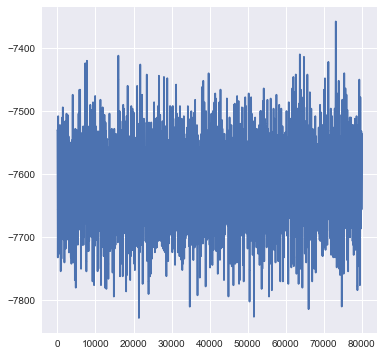

In [5]:
plt.figure(figsize=(6,6))
plt.plot(energy[int(0.2*N):])


Total ESS: 1945.7981686847072
ESS/S: 0.2971783318469158


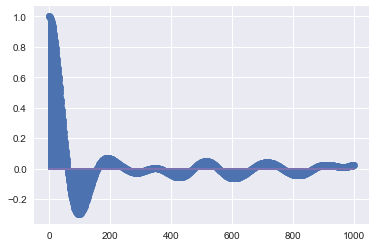

In [6]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy[int(0.2*N):], np.arange(0, 1000)))
ESS_E = (0.8*N)/(1+2*sum(autocorr(energy[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime)

Continuous-time Zanella

In [7]:
# T = 250
T = 50
thinning_ratio = 0.0005
N = int(T/thinning_ratio)
samples_z, energy_z, hammings_z, alpha_z, iters_z, runtime_z = tabu_sampler(n, n, 
                                                       energy_function=energy_func, 
                                                       calculate_rates=calc_rates_barker, 
                                                       update_rates=upd_rates_barker, 
                                                       apply_generator=apply_gen, 
                                                       current_state=np.ones(n), 
                                                       baseline_state=-np.ones(n), 
                                                       target_time=T, 
                                                       thin_rate=thinning_ratio, 
                                                       time_change_rate=10,
                                                       symmetry=False,
                                                       SAW_bool=False,
                                                      print_output=False,
                                                       print_rate=100,
                                                     calc_hamming=False)

Percent: [--------------------------------------->] 100%[50.000081]
Average jump length: [0.00048173]
Runtime: 6576.3


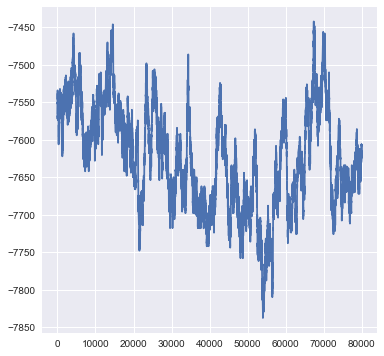

In [8]:
plt.figure(figsize=(6,6))
plt.plot(energy_z[int(0.2*N):])

Total ESS: 22.826844974116852
ESS/S: 0.0034710749176922167


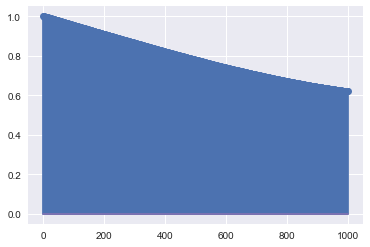

In [9]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy_z[int(0.2*N):], np.arange(0, 1000)))
ESS_E_Z = (0.8*N)/(1+2*sum(autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E_Z)
print("ESS/S:", ESS_E_Z/runtime_z)